#Import Library

In [ ]:
#Import Libraries

import os
from itertools import chain
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io.json import json_normalize
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
#pip install spacy==2.2.3
#python -m spacy download en_core_web_sm
#pip install beautifulsoup4==4.9.1
#pip install textblob==0.15.3
from dataclasses import dataclass
import spacy.cli
import spacy
#spacy.cli.download("en_core_web_sm",'--no-deps')

#download("en_core_web_sm")


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# load Data

In [ ]:
path = "/content/tweets_ws22_v1.json"

In [ ]:
with open(path) as f:
    dump = json.loads(f.read())
    org_df = pd.json_normalize(dump)
    org_df
    


final_df = pd.DataFrame() 

for i in range(0,len(dump)):
    temp_topic_df = pd.json_normalize(dump[i]['labels']['topic'])
    temp_sentiment_df = pd.json_normalize(dump[i]['labels']['sentiment'])
    temp_topic_df.rename(columns={'id':'topic_id','tweet_id':'topic_tweet_id','user_id':'topic_user_id','ground_truth':'topic_ground_truth'}, inplace = True)
    temp_sentiment_df.rename(columns={'id':'sentiment_id','tweet_id':'sentiment_tweet_id','user_id':'sentiment_user_id','ground_truth':'sentiment_ground_truth'}, inplace = True)
    df_join_topic_sent = temp_topic_df.join(temp_sentiment_df)
    final_df = final_df.append(df_join_topic_sent)
    #final_df = pd.concat([org_df,Joined_df],axis = 1)
    
    
cols = final_df.columns
org_df[cols] = final_df[cols].values


data =  org_df.drop(columns=['labels.topic','labels.sentiment','topic_tweet_id','sentiment_tweet_id','author_id','source','topic_user_id','topic_ground_truth','language','id','source_id','relevant','sentiment_ground_truth','sentiment_id','topic_id','sentiment_user_id'])
data

,source_created_at,text,longitude,latitude,topic,sentiment
0,2020-09-18 21:56:20.798000,@DSisourath The Thameslink core between London...,-0.12574,51.50853,service,negative
1,2020-10-13 07:31:53.122000,@DulwichHistory Loving the complaint about peo...,-0.12574,51.50853,delays,negative
2,2020-10-26 19:27:24.695000,@SW_Help .And yet you have no toilets on some ...,-0.12574,51.50853,toilets,negative
3,2020-10-26 19:28:49.281000,@SW_Help you have no toilets on some of your t...,-0.12574,51.50853,toilets,negative
4,2020-09-28 11:59:41.212000,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,-1.09125,50.79899,seats,neutral
...,...,...,...,...,...,...
16944,2019-07-11 07:34:35,Haha oh man the audio corruption on @TLRailUK ...,NaN,NaN,announcements,neutral
16945,2020-08-10 11:19:10.181000,@TLRailUK SweetIs there a plug to charge my ph...,-0.12574,51.50853,plugs,neutral
16946,2020-08-29 09:51:10.833000,@TLRailUK now there are far fewer commuters ha...,-0.12574,51.50853,tables,neutral
16947,2020-11-02 12:06:06.967000,@geofftech I am voting for Thameslink. 1. in a...,-0.12574,51.50853,toilets,neutral


#Check Data

In [ ]:
df = pd.DataFrame(data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


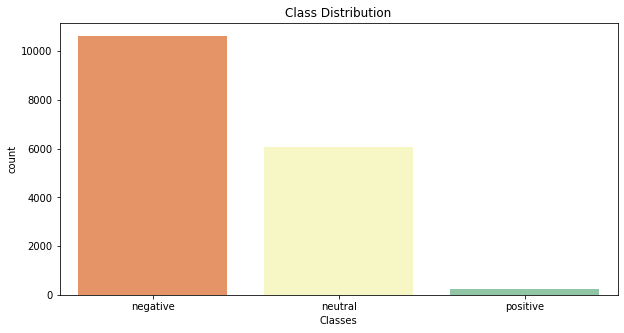

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(df.sentiment, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

In [ ]:
#store classes into an array
possible_labels = df.sentiment.unique()
possible_labels

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
#convert labels into numeric values
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
label_dict

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
#convert labels into numeric values
df['label'] = df.sentiment.replace(label_dict)
df.head(10)

,source_created_at,text,longitude,latitude,topic,sentiment,label
0,2020-09-18 21:56:20.798000,@DSisourath The Thameslink core between London...,-0.12574,51.50853,service,negative,0
1,2020-10-13 07:31:53.122000,@DulwichHistory Loving the complaint about peo...,-0.12574,51.50853,delays,negative,0
2,2020-10-26 19:27:24.695000,@SW_Help .And yet you have no toilets on some ...,-0.12574,51.50853,toilets,negative,0
3,2020-10-26 19:28:49.281000,@SW_Help you have no toilets on some of your t...,-0.12574,51.50853,toilets,negative,0
4,2020-09-28 11:59:41.212000,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,-1.09125,50.79899,seats,neutral,1
5,2020-10-12 10:08:17.434000,@TLRailUK @SW_Help @SouthernRailUK @TfL Yyyiou...,-0.12574,51.50853,delays,negative,0
6,2020-10-12 10:08:17.434000,@TLRailUK @SW_Help @SouthernRailUK @TfL Yyyiou...,-0.12574,51.50853,service,negative,0
7,2020-09-04 19:01:37.077000,@TLRailUK On the Bedford to Brighton route - w...,-0.12574,51.50853,wifi,negative,0
8,2020-10-10 15:33:31.480000,@TLRailUK The delay repay is asking for a requ...,-0.12574,51.50853,tickets/seat_reservations,negative,0
9,2020-08-13 18:58:23.281000,@TLRailUK announced a cancelled train > 2 mins...,-0.33333,51.75000,delays,negative,0


###convert labels into numeric values

In [ ]:
df['label'] = df.sentiment.replace(label_dict)
df.head(10)

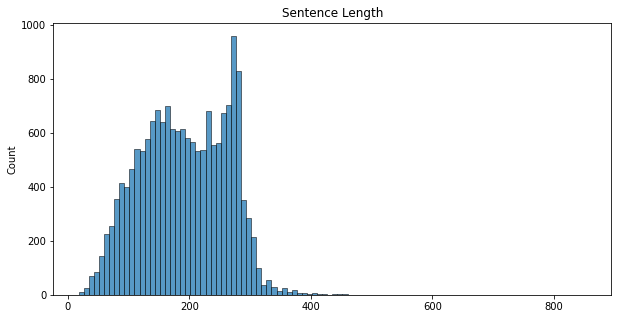

In [ ]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
#find the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  853


In [ ]:
df[["text","sentiment"]]

,text,sentiment
0,@DSisourath The Thameslink core between London...,negative
1,@DulwichHistory Loving the complaint about peo...,negative
2,@SW_Help .And yet you have no toilets on some ...,negative
3,@SW_Help you have no toilets on some of your t...,negative
4,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,neutral
...,...,...
16944,Haha oh man the audio corruption on @TLRailUK ...,neutral
16945,@TLRailUK SweetIs there a plug to charge my ph...,neutral
16946,@TLRailUK now there are far fewer commuters ha...,neutral
16947,@geofftech I am voting for Thameslink. 1. in a...,neutral


#Split Data

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_test, y_train, y_test = train_test_split(df.index.values, df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [ ]:
#create new column
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

,source_created_at,text,longitude,latitude,topic,sentiment,label,data_type
0,2020-09-18 21:56:20.798000,@DSisourath The Thameslink core between London...,-0.12574,51.50853,service,negative,0,not_set
1,2020-10-13 07:31:53.122000,@DulwichHistory Loving the complaint about peo...,-0.12574,51.50853,delays,negative,0,not_set
2,2020-10-26 19:27:24.695000,@SW_Help .And yet you have no toilets on some ...,-0.12574,51.50853,toilets,negative,0,not_set
3,2020-10-26 19:28:49.281000,@SW_Help you have no toilets on some of your t...,-0.12574,51.50853,toilets,negative,0,not_set
4,2020-09-28 11:59:41.212000,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,-1.09125,50.79899,seats,neutral,1,not_set


In [ ]:
#fill in data type
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
df.groupby(['sentiment', 'label', 'data_type']).count()

source_created_at  text  longitude  latitude  topic
sentiment label data_type                                                     
negative  0     test                    1595  1595        108       108   1595
                train                   9033  9033        624       624   9033
neutral   1     test                     912   912         86        86    912
                train                   5167  5167        558       558   5167
positive  2     test                      36    36          5         5     36
                train                    206   206         44        44    206

#Imbalance

In [ ]:
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'sentiment']);

#Tokenize

In [ ]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.8 MB/s 
     |████████████████████████████████| 182 kB 44.8 MB/s 
     |████████████████████████████████| 7.6 MB 51.7 MB/s 


In [ ]:
#load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#tokenize train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#tokenizer test set
encoded_data_test = tokenizer.batch_encode_plus(df[df.data_type == 'test'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [ ]:
encoded_data_train

{'input_ids': tensor([[  101,  1030, 16233,  ...,     0,     0,     0],
        [  101,  1030, 25430,  ...,     0,     0,     0],
        [  101,  1030, 25430,  ...,     0,     0,     0],
        ...,
        [  101,  1030,  1056,  ...,     0,     0,     0],
        [  101,  1030, 14915,  ...,     0,     0,     0],
        [  101,  1030, 14915,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

#One hot encoding

In [ ]:
y_train_le = y_train.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 14406
TESTING DATA: 2543


#BERT Sentiment Analysis

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [ ]:
#tokenize train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#tokenizer test set
encoded_data_test = tokenizer.batch_encode_plus(df[df.data_type == 'test'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

#Encoding

In [ ]:
#encode train set
! pip install torchvision 
import torch
import torchvision
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#encode test set
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

#convert data type to torch.tensor
labels_test = torch.tensor(df[df.data_type == 'test'].label.values)

In [ ]:
input_ids_train

tensor([[  101,  1030, 16233,  ...,     0,     0,     0],
        [  101,  1030, 25430,  ...,     0,     0,     0],
        [  101,  1030, 25430,  ...,     0,     0,     0],
        ...,
        [  101,  1030,  1056,  ...,     0,     0,     0],
        [  101,  1030, 14915,  ...,     0,     0,     0],
        [  101,  1030, 14915,  ...,     0,     0,     0]])

In [ ]:
attention_masks_train

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
#create dataloader
dataset_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

14406
2543


In [ ]:
dataset_train

In [ ]:
dataset_train.tensors

(tensor([[  101,  1030, 16233,  ...,     0,     0,     0],
         [  101,  1030, 25430,  ...,     0,     0,     0],
         [  101,  1030, 25430,  ...,     0,     0,     0],
         ...,
         [  101,  1030,  1056,  ...,     0,     0,     0],
         [  101,  1030, 14915,  ...,     0,     0,     0],
         [  101,  1030, 14915,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]))

#Bert Modeling

In [ ]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from transformers import BertForSequenceClassification

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(label_dict), output_attentions = False, output_hidden_states = False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #since we have limited resource

#load train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#load test set
dataloader_test = DataLoader(dataset_test,
                              sampler = RandomSampler(dataset_test),
                              batch_size = 32) #since we don't have to do backpropagation for this step

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

#load optimizer
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5

In [ ]:
#load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(dataloader_train)*epochs)

In [ ]:
#preds = [0.9 0.05 0.05 0 0 0]
#preds = [1 0 0 0 0 0]
import numpy as np
from sklearn.metrics import f1_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):

    #evaluation mode disables the dropout layer 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
!pip install tqdm
from tqdm import tqdm
for epoch in tqdm(range(0,1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0
    
    #set up progress bar
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()
        
        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


串流輸出內容已截斷至最後 5000 行。
100%|██████████| 1/1 [7:32:33<00:00, 27153.10s/it]


Epoch {epoch}


In [ ]:
model.save_pretrained('/content/drive/MyDrive/NLP/save_model/nlp_frist.hdf5')

In [ ]:
loss_train_avg=loss_train_total/len(dataloader_train)

In [ ]:
loss_train_avg = loss_train_total/len(dataloader_train)
tqdm.write(f'Training loss: {loss_train_avg}')

Training loss: 0.612968370491129


In [ ]:
dataloader_test

In [ ]:
#evaluate
evaluate(dataloader_test)

100%|██████████| 80/80 [20:49<00:00, 15.62s/it]


(0.6291996493935585, array([[ 3.5494728 , -0.3607211 , -3.6052618 ],
        [-0.07526054,  2.2818298 , -2.4425824 ],
        [ 1.427885  ,  2.2298937 , -3.6499577 ],
        ...,
        [ 0.7674154 ,  2.658     , -3.4040294 ],
        [ 3.5294101 , -0.68103516, -3.1992736 ],
        [ 2.559667  ,  0.43644398, -3.5635693 ]], dtype=float32), array([0, 1, 0, ..., 1, 0, 0]))

In [ ]:
 val_loss, predictions, true_vals = evaluate(dataloader_test)

100%|██████████| 80/80 [21:28<00:00, 16.11s/it]


In [ ]:
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'F1 Score (weighted): {val_f1}')

F1 Score (weighted): 0.7394850598513708


In [ ]:
accuracy_per_class(predictions, true_vals)

Class: negative
Accuracy:1384/1595

Class: neutral
Accuracy:521/912

Class: positive
Accuracy:2/36



In [ ]:
outputs.loss

tensor(0.3580, grad_fn=<NllLossBackward0>)

In [ ]:
outputs.logits

tensor([[-0.2996,  2.7314, -2.6870],
        [ 1.9016,  1.8409, -3.9573]], grad_fn=<AddmmBackward0>)

In [ ]:
#save model
model.to(device)
pass

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset_test,y_preds))

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #since we have limited resource

#load train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#load test set
dataloader_test = DataLoader(dataset_test,
                              sampler = RandomSampler(dataset_test),
                              batch_size = 32) #since we don't have to do backpropagation for this step

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           